# Light propagation involving polarisation

Light propagating with two levels of polarisation dependence: 
1. a bi-refringent medium, which we model by having two distinct wave-vectors for the horizontal and vertical components
2. Atoms that have some polarisation dependence to their absorption. This means they respond primarily to a particular combination of H/V polarisation, and re-radiate that combination when excited.


Main example:
* Polarised atom, with birefringence
* Photon echoes in said medium



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from pylab import *
from spylind import spyIVP as svp
from spylind import spylind as spl 
from spylind import utils as ut
import sympy as sm
import qutip as q
import pdb
sm.init_printing() # this is needed to display equations nicely


def tophat(t, width, center=0):
    return where( abs(t-center)< width/2, 1.0, 0)
def lor(t,width, center=0):
    '''
    Lorentzian,
    width is fwhm

    '''
    return (width/2)**2 /( (t-center)**2 + (width/2)**2 )

def gauss(t,width, center=0):
    '''
    Gaussian function, t is axis,
    width is FWHM
    '''
    return( np.exp(   -pow(t-center,2)/( width**2/(4*np.log(2)) )    ) )

def hyp_sec(t, width, center=0):
    return 1./cosh((t-center)/width)#*1.76){

Tensorflow not accessible: No module named 'backend_tf'
No pretty printing stuff (probably because no Pandas)


# Atom description (2-level)

We'll just use a two-level system. In this case we'll assume it's dipole moment oriented along 1 axis only

In [2]:
K1, K2  = q.basis(2,0), q.basis(2,1)
tS, zS, DeltaS = sm.symbols('t, z, Delta', real=True) #dimensions
EHexS,EHintS, = sm.symbols('E^H_ex, E^H_int', complex=True)
EVexS,EVintS, = sm.symbols('E^V_ex, E^V_int', complex=True)
H_modeS, V_modeS = sm.symbols("M_h, M_v", complex=True)
Hdet = sm.Matrix(K2*K2.dag()) #Detuning of the excited state (inhomogeneous broadening)

# Atom polarisation parameters
aH_S, aV_S = sm.symbols("a_H, a_V", complex=True)# Something like complex Jones parameters. 
OD_S = sm.symbols("OD", real=True) # Optical depth when atome dipole moment is 1
det0_S = sm.symbols("Delta_0", real=True) # Detuning of line center

HHa = aH_S*sm.Matrix(K2*K1.dag()) #Convert everything to sympy matrices so we get nice eequation printing
HVa = aV_S*sm.Matrix(K2*K1.dag())

c_opL = [sm.sqrt(.01)*K1*K2.dag() ] # optical decay rate
HHa_coef = (EHexS*H_modeS + EHintS) # Horizontal field seen by atoms
HVa_coef = (EVexS*V_modeS + EVintS) # Vertical ""

H_desc = [0*Hdet, [HHa_coef, HHa], [sm.conjugate(HHa_coef), HHa.adjoint()], 
                [HVa_coef, HVa], [sm.conjugate(HVa_coef), HVa.adjoint()], 
          [DeltaS + det0_S, 2*sm.pi*Hdet] ]

dy_dtD, [pol_H_expr, pol_V_expr],pretty_eq= spl.makeMESymb(H_desc, c_opL=c_opL, e_opL = [OD_S*sm.conjugate(HHa), OD_S*sm.conjugate(HVa)], bReturnPrettyEquation=True)
display(pretty_eq)
display("Polarisation expression, H/V: ", [pol_H_expr, pol_V_expr])

<IPython.core.display.Latex object>

'Polarisation expression, H/V: '

In [3]:
sys = svp.ODESys(dy_dtD, trans_dims={zS: linspace(0,20,1200),
              DeltaS: linspace(-0.02, 0.02,2)}, 
                 #intermediate_calcs = [sm.conjugate(pol_H_expr), sm.conjugate(pol_V_expr)],
                 intermediate_calcs = [pol_H_expr, pol_V_expr],
                 driving_syms=[EVexS, EHexS], 
                 state_dep_syms = [EHintS, EVintS],
                 constant_syms = [H_modeS, V_modeS],
                )
sys.summary()

**Function signatures:**

state_dep_f( $\displaystyle t$, dimAxes = $[ \displaystyle z, \displaystyle \Delta ]$, state = $[ \displaystyle \rho_{0|0}, \displaystyle \rho_{1|1}, \displaystyle \rho_{0|1} ]$, driving= $[ \displaystyle E^{V}_{ex}, \displaystyle E^{H}_{ex} ]$, intermediate = $[ \displaystyle I_{0}, \displaystyle I_{1} ]$ )

output_f( $\displaystyle t$, dimAxes = $[ \displaystyle z, \displaystyle \Delta ]$, state = $[ \displaystyle \rho_{0|0}, \displaystyle \rho_{1|1}, \displaystyle \rho_{0|1} ]$, driving= $[ \displaystyle E^{V}_{ex}, \displaystyle E^{H}_{ex} ]$, state_dependent= $[ \displaystyle E^{H}_{int}, \displaystyle E^{V}_{int} ]$ , intermediate = $[ \displaystyle I_{0}, \displaystyle I_{1} ]$ )

**Variables:**

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# The field(s)

In [8]:
# 

def setup_fields(sys, dn =0.1, line_shape_f = lambda Delta: 1.0):
    """ Add the two different polarisation modes to the system.
    
    @sys is an ODESys. 
    @dn is the difference in refractive index between the two modes
    @line_shape_f is a function that gives the OD as a function of detuning
    """

    zAx = sys.dims.axes_broadcastable[zS]
    deltaAx = sys.dims.axes_broadcastable[DeltaS]
    zAxIndex = list(sys.dims.axes).index(zS) # = 0
    deltaAxIndex = list(sys.dims.axes).index(DeltaS) # = 1
    dz = abs(diff(zAx, axis=zAxIndex).mean())#zAx[1] - zAx[0] # These are needed to normalise optical depth
    dDelta = abs(diff(deltaAx, axis=deltaAxIndex).mean())#zAx[1] - zAx[0] # These are needed to normalise optical depth

    # This is the desired lineshape (when the dipole size is 1)
    absorption_lineshape = line_shape_f(deltaAx) 
    # This is the one used in calculation. The peak OD is accurate with the assumption that inhomogeneous >> homogeneous broadening
    scaled_lineshape = absorption_lineshape*(dDelta/zAx.size) 


    def calc_H_polF(t, dimAxs, state, driving, intermediate_vals, constants,
                deltaAxI = deltaAxIndex, zAxI = zAxIndex, scaled_lineshape=scaled_lineshape):
        mode = constants[0]
        pol = intermediate_vals[0]#.conj() #pol_H_expr
        pol = (pol*scaled_lineshape).sum(axis=deltaAxI, keepdims=True)
        pol = np.cumsum(pol*mode.conj(), axis= zAxI)*mode
        E_rad = 1j*pol
        return E_rad

    def calc_V_polF(t, dimAxs, state, driving, intermediate_vals, constants,
                deltaAxI = deltaAxIndex, zAxI = zAxIndex, scaled_lineshape=scaled_lineshape):
        mode = constants[1]
        pol = intermediate_vals[1]#.conj() #pol_V_expr
        pol = (pol*scaled_lineshape).sum(axis=deltaAxI, keepdims=True)
        pol = np.cumsum(pol*mode.conj(), axis= zAxI)*mode
        E_rad = 1j*pol
        return E_rad


    def calc_output_fields(t, state, driving, _intermediate_vals, state_dependent):
        E_ex_H, E_ex_V = driving
        E_rad_H, E_rad_V = state_dependent
        #Eout = mode_H*(E_ex_H + E_rad_H), mode_V*(E_ex_V + E_rad_V)
        Eout = (E_ex_H*mode_H + E_rad_H), (E_ex_V*mode_V + E_rad_V)
        return Eout

    mode_H = exp(1j*zAx*0)
    mode_V = exp(1j*zAx*dn)
    sys.constantsD.update({H_modeS: mode_H, V_modeS: mode_V})
    sys.set_state_dependence({EHintS: calc_H_polF, 
                              EVintS: calc_V_polF})
    sys.set_outputs(calc_output_fields)
    sys.set_initial_state(array([1,0,0]))
setup_fields(sys, dn =0.1)

In [9]:
t_E = linspace(0,5,100)
Ein_H = 10*gauss(t_E, width=1.5, center=2) 
Ein_V = (0+0j)*gauss(t_E, width=1.5, center=2) 
sys.set_driving({EHexS: (t_E, Ein_H), EVexS: (t_E, Ein_V) })
paramsD = {aH_S: 1 , #careful of setting one of these to zero (may have unexpected consequences)
           aV_S: 1j,
           OD_S: 100,
           det0_S: 0.0, # Line center frequency
          }
tSteps = linspace(0,10,1000)
sim = sys.setup_model(substitutionsD = paramsD)
%time res = sim.integrate(tSteps)

CPU times: user 2.18 s, sys: 27.1 ms, total: 2.21 s
Wall time: 2.22 s


## Plotting the results

In [6]:
sys.dims.axes[zS]

array([0.00000000e+00, 1.66805671e-02, 3.33611343e-02, ...,
       1.99666389e+01, 1.99833194e+01, 2.00000000e+01])

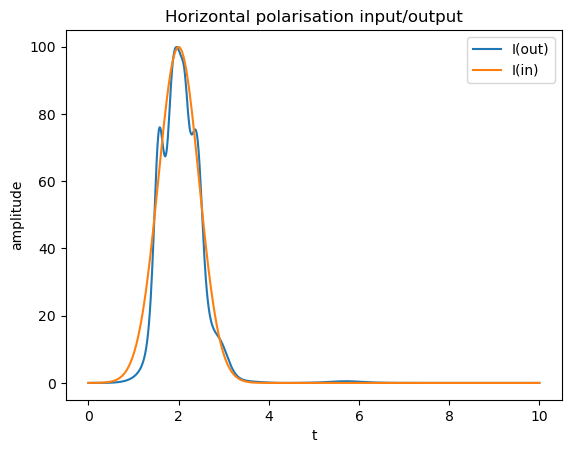

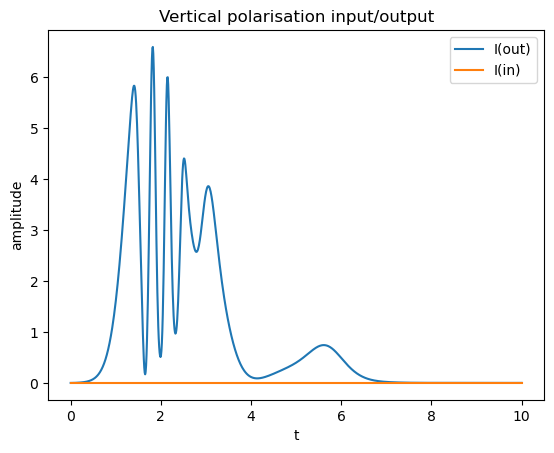

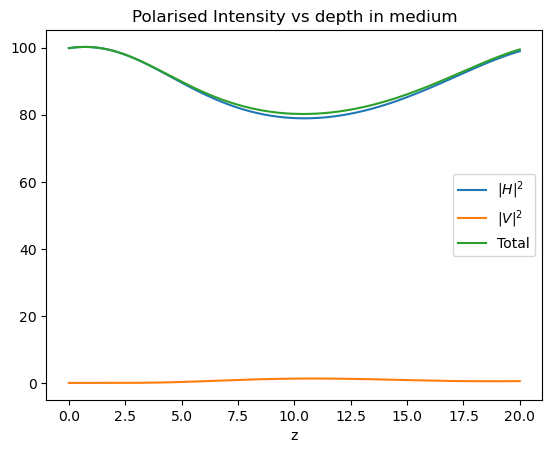

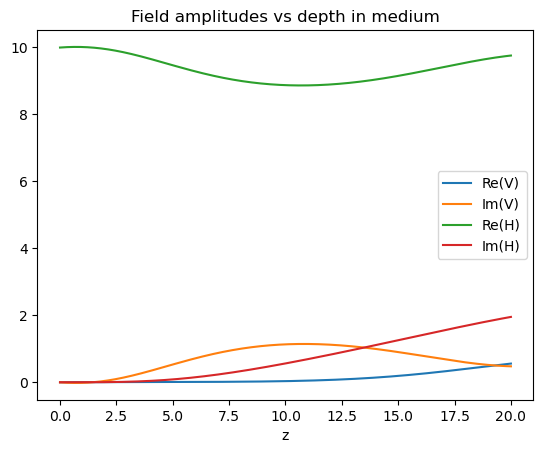

In [7]:
def plot_res(res, sys, tSteps):
    """ Some graphs to plot
    """
    zAx = sys.dims.axes[zS]
    Ein_H, Ein_V = [sys.driving_funcs_D[sym](tSteps) for sym in [EHexS, EVexS]]
    Eout_H = res[:,0]
    Eout_V = res[:,1]
    plot(tSteps, abs(Eout_H[:,-1])**2, label='I(out)')
    plot(tSteps, abs(Ein_H)**2, label='I(in)')
    legend()
    xlabel('t')
    ylabel('amplitude')
    title("Horizontal polarisation input/output")

    figure()
    plot(tSteps, abs(Eout_V[:,-1])**2, label='I(out)')
    plot(tSteps, abs(Ein_V)**2, label='I(in)')
    legend()
    xlabel('t')
    ylabel('amplitude')
    title("Vertical polarisation input/output")

    ind = tSteps.searchsorted(2) #Look during the peak of the pulse
    figure()
    plot(zAx, np.abs(Eout_H[ind])**2, label = "$|H|^2$" )
    plot(zAx, np.abs(Eout_V[ind])**2, label = "$|V|^2$")
    plot(zAx, np.abs(Eout_H[ind])**2 + np.abs(Eout_V[ind])**2, label = "Total")
    xlabel("z")
    title("Polarised Intensity vs depth in medium")
    legend()

    figure()
    plot(zAx, Eout_V[ind].real, label="Re(V)")
    plot(zAx, Eout_V[ind].imag, label="Im(V)")
    plot(zAx, Eout_H[ind].real, label="Re(H)")
    plot(zAx, Eout_H[ind].imag, label="Im(H)")
    xlabel("z")
    title("Field amplitudes vs depth in medium")
    legend()
    
plot_res(res, sys, tSteps)

CPU times: user 2.97 s, sys: 29.8 ms, total: 3 s
Wall time: 3 s


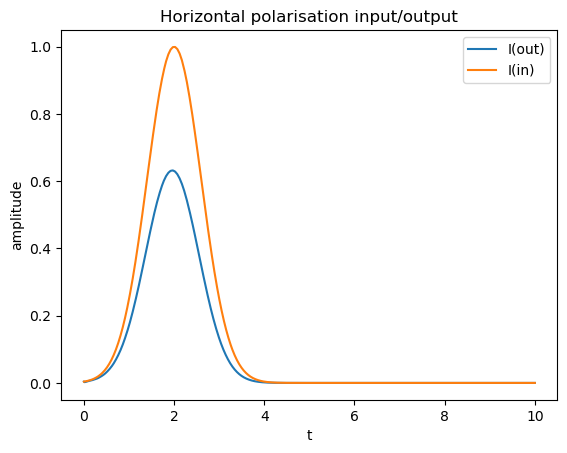

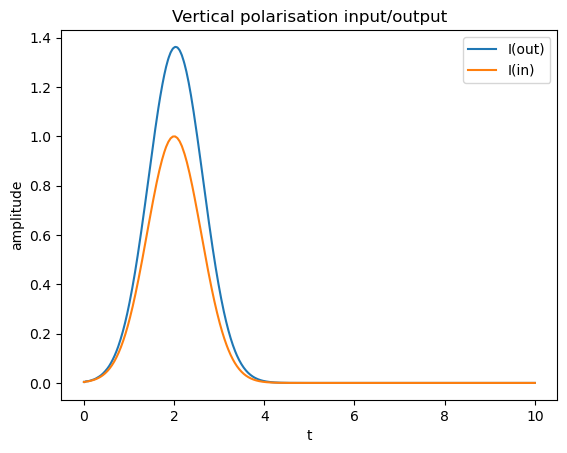

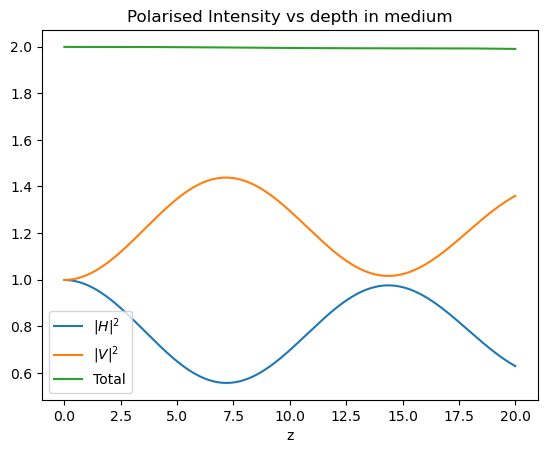

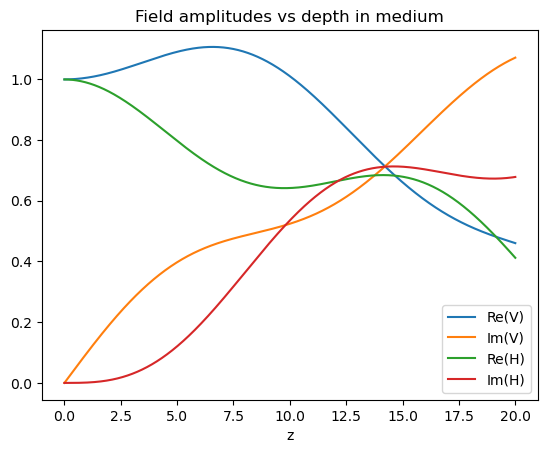

In [19]:

t_E = linspace(0,5,100)
Ein_H = (1+0j)*gauss(t_E, width=2, center=2) 
Ein_V = (1+0j)*gauss(t_E, width=2, center=2) 
sys.set_driving({EHexS: (t_E, Ein_H), EVexS: (t_E, Ein_V) })
paramsD = {aH_S: 1j , #careful of setting one of these to zero (may have unexpected consequences)
           aV_S: -1j,
           OD_S: 1000,
           det0_S: 3.0, # Line center frequency
          }
tSteps = linspace(0,10,1000)
sim = sys.setup_model(substitutionsD = paramsD)
%time res = sim.integrate(tSteps)
plot_res(res, sys, tSteps)

# Photon echoes


In [20]:

sys = svp.ODESys(dy_dtD, trans_dims={zS: linspace(0,20,100),
              DeltaS: linspace(-4, 4, 200)}, 
                 #intermediate_calcs = [sm.conjugate(pol_H_expr), sm.conjugate(pol_V_expr)],
                 intermediate_calcs = [pol_H_expr, pol_V_expr],
                 driving_syms=[EVexS, EHexS], 
                 state_dep_syms = [EHintS, EVintS],
                 constant_syms = [H_modeS, V_modeS],
                )
setup_fields(sys, dn=0.0)

In [37]:
t_E = linspace(0,10,200)
inp_pulse = 1/sqrt(2)*array([1, 1])[:,newaxis] * 0.2*gauss(t_E, width=1.5, center=1.5) 
pi_pulse =  1/sqrt(2)*array([1, 1])[:,newaxis] * 2.5/.5*tophat(t_E, width=.5, center=6.5) 
Ein_H = inp_pulse[0] + pi_pulse[0]
Ein_V = inp_pulse[1] + pi_pulse[1]
sys.set_driving({EHexS: (t_E, Ein_H), EVexS: (t_E, Ein_V) })
paramsD = {aH_S: 1.0 , #careful of setting one of these to zero (may have unexpected consequences)
       aV_S: .000001,
           OD_S: 2.5,
           det0_S: 0.0, # Line center frequency
          }
sim = sys.setup_model(substitutionsD = paramsD)

tSteps = linspace(0,15,300)
%time res = sim.integrate(tSteps)

CPU times: user 21.6 s, sys: 22.6 ms, total: 21.6 s
Wall time: 21.7 s


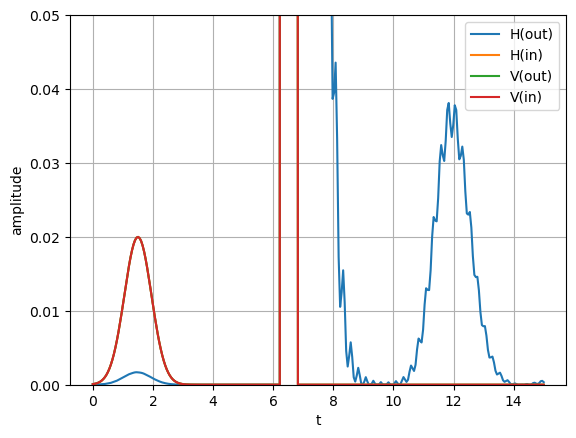

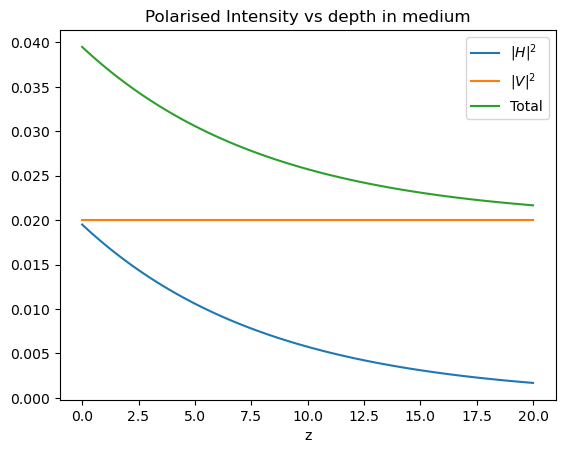

In [38]:
def plot_res(res, sys, tSteps, ylm1 = None, t1=1.5):
    zAx = sys.dims.axes[zS]
    Ein_H, Ein_V = [sys.driving_funcs_D[sym](tSteps) for sym in [EHexS, EVexS]]
    Eout_H = res[:,0]
    Eout_V = res[:,1]
    plot(tSteps, abs(Eout_H[:,-1])**2, label='H(out)')
    plot(tSteps, abs(Ein_H)**2, label='H(in)')
    plot(tSteps, abs(Eout_V[:,-1])**2, label='V(out)')
    plot(tSteps, abs(Ein_V)**2, label='V(in)')
    #plot(tSteps, abs(Eout_H[:,-1])**2+ abs(Eout_V[:,-1])**2, label='T(out)')
    legend()
    xlabel('t')
    ylabel('amplitude')
    ylim(ylm1)
    grid()

    ind = tSteps.searchsorted(t1) #Look during the peak of the pulse
    figure()
    plot(zAx, np.abs(Eout_H[ind])**2, label = "$|H|^2$" )
    plot(zAx, np.abs(Eout_V[ind])**2, label = "$|V|^2$")
    plot(zAx, np.abs(Eout_H[ind])**2 + np.abs(Eout_V[ind])**2, label = "Total")
    xlabel("z")
    title("Polarised Intensity vs depth in medium")
    legend()
    
plot_res(res, sys, tSteps, ylm1 = [0,0.05])

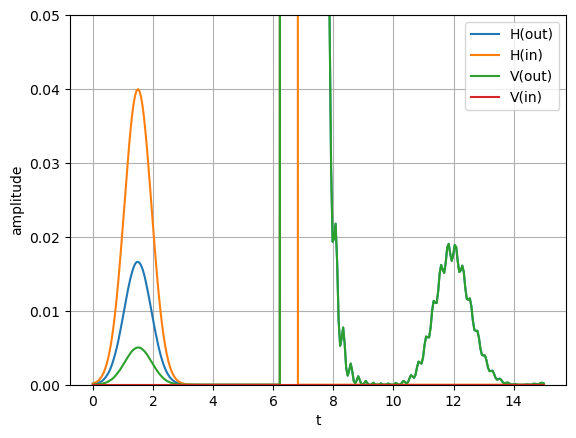

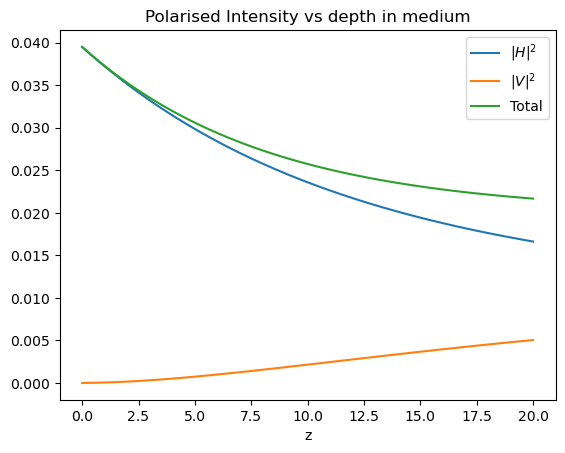

In [32]:

plot_res(res, sys, tSteps, ylm1 = [0,0.05])

## Future interface, maybe:

In [411]:
model.initial_state[:] = 0 #set all to zero
model.initial_state[0] = 1 # set just ground state to 1
Ein_H = 0.1*gauss(t, width=5, center=5) + 0j
Ein_V = 0.1*gauss(t, width=5, center=5) + 0j
model.params[EHexS].y[:] = Ein_H
model.params[EVexS].y[:] = Ein_V
tSteps = linspace(0,30,2000)
%time res = model.integrate(tSteps, driving= [Ein_H, Ein_V])
# res should be a list of output fields, not states

NameError: name 'model' is not defined

# Scrap
How I want it to look (if spyIVP were written nicely)

For the atoms, pretty much the same as above.


For the field, I don't want this bit (1)
```
pol_H_F=sm.lambdify( evoD.keys(), pol_H_expr.subs(paramsD), 'numpy')
pol_V_F=sm.lambdify( evoD.keys(), pol_V_expr.subs(paramsD), 'numpy')
```
while the subsitution in the driving field  (2)
```
sys.set_driving({EHexS: Ein_expr_H.subs(paramsD), EVexS: Ein_expr_V.subs(paramsD) })
```
is also a bit crap.

Finally, the final data processing (3):
```
state = np.moveaxis(res, 0,-1) #Move the time axis to the end, so state axis is at the start 
                                #and we can use polF(*state)
pol_H = (pol_H_F(*state)*scaled_lineshape[..., newaxis]).sum(axis=deltaAxIndex) # This comes from calcPolFuncF
pol_V = (pol_V_F(*state)*scaled_lineshape[..., newaxis]).sum(axis=deltaAxIndex) # This comes from calcPolFuncF

Ein_H = sm.lambdify(tS, Ein_expr_H.subs(paramsD), 'numpy')(tSteps)
Ein_V = sm.lambdify(tS, Ein_expr_V.subs(paramsD), 'numpy')(tSteps)
Ein_V = zeros(tSteps.size) if np.size(Ein_V) == 1 else Ein_V # In case one direction is sympy collapses ths size
Ein_H = zeros(tSteps.size) if np.size(Ein_H) == 1 else Ein_H


#Eout_H = 1j*pol_H.cumsum(axis=0)  + Ein_H[newaxis] # Actual field is the sum of the input + atom polarisation
#Eout_V = 1j*pol_V.cumsum(axis=0)  + Ein_V[newaxis]

Eout_H = np.array([calc_H_polF(cur_state).squeeze() for cur_state in res]) + Ein_H[:,newaxis]
Eout_V = np.array([calc_V_polF(cur_state).squeeze() for cur_state in res]) + Ein_V[:,newaxis]
```
is duplicating code, especially re-lambdifying the field

For 1):

I want to add an extra parameter to the `ODESys`, that somehow gives symbols that need to be calculated so that state_dependent funcs can use them, or to avoid re-calculation by the evolution functions. Could call them "pre_calcs" or "calc_first" or something. This could be just extra symbollic expressions, or maybe also numerical ones. In any case, we should be fine with just symbollic for the moment. E.g. `calc_first = {P_S: pol_expr}`. Then `state_dependent_funcs` will have an extra parameter `other_vars` (names could still use work!). 

For 2):

The annoying bit here is that the input polarisation should really be a parameter, so that we could call `setup_model({theta_S: pi/4})` or something. But currently there's no easy way to set the driving field on the model object, or even to substitute for the driving symbols on model setup. 

Possible solutions: 
* don't use driving functions with anything symbollic. Just substitute the t-dependent expression at the last minute.
    * A major negative is slowness, and it doesn't cover last minute changes for numerical 'driving'
    * Could easily enough do a comnination- a symbollic parameter and a driving func
    * Would Still need a way to set driving funcs on a model.
* Somehow allow driving funcs _and_ parameters to be assigned at the 'model' level
    * In this case the _driving_ probably wouldn't be 'funcs' exactly, rather arrays that get interpolated.
    * Setting parameter on the model would be setting these arrays. 
    * This has nice overlap with the way we'd do it in tensorflow
    * Should be still able to specify a function instead of an interpolation.
    * Ideally, that would be modifable too...
    


For 3)

When doing the final analysis step, we need to re-do a bunch of analyses that were already done during the simulation. And it means doing things kinda of awkwardly. Specifically, we want to calculate and save the output field at the same time during the simulation. I think this just means having state and other functions as parameters of the output_func- essentialy the same signature as a state_dependent function. The challenge here is that currently all that stuff is wrapped up in dy_dt_fast, and only the state derivative comes out. Another factor is that it's a bit different for the Tensorflow version, since in that solver we don't get access to the state until right at the end. So in other words, for this solver, we can't really do 'online' solving, unless we use a side effect of the derivative function itself. And _that_ doesn't seem sensible.

So, I think the two possible approaches are:
1. Try to make it easy to access all the functions (state dependent, co_calcs etc) outside of the 'model' object, OR
2. Re-do the model/ODESys breakdown so that the functions are accessible _within_ the model object, and do the analysis in there.


Lets think these through. The tricky part is that we want access to all the required arguments: `co_calcs`, `driving`, `state_dependent`, and the `state` itself, for the points in time in `tSteps`. These are currently attributes of the `dy_dt` object. We could add another method, `calc_output(self, t,state)` to this. Then from `Model` we can call this once in a while. It does mean re-doing some of those calcs, but that's probably not a big deal? Or we could add a `calc_current_parameters(t, state)` method, which returns all the non-state parameters? Then we can call that from `Model`.

This sounds like it will work. But will adding the `calc_current_parameters` method h elp solve problems 1) and 2) as well?

For 2), we want to be able to do say `model.change_driving({E_S: some_array})`, or maybe `model.driving_interp[E_S] = new_array`. This means model needs access to `dy_dt_fast`'s attributes.


In [6]:
import tensorflow as tf
import numpy as np
from numpy import linspace

In [39]:
tf.function(experimental_compile=True)
def f(t, y):
    val = t+y*y + t**2
    val = val*tf.exp(y)*tf.sin(t)**2
    val = val**3*tf.exp(t)/tf.math.log(val**2+1000)
    val = val*val/(val-1)+t**2
    #return np.sum(val, axis=0)
    return tf.reduce_sum(val, axis=0)
    
def f2(t, y):
    val = t+y*y + t**2
    val = val*np.exp(y)*np.sin(t)**2
    val = val**3 *np.exp(t)/np.log(val**2+1000)
    val = val*val/(val-1)+t**2
    return np.sum(val, axis=0)

In [50]:
t_= linspace(0,1,1000000).reshape(1000,1000).astype('f4')
with tf.device("/device:CPU:0"):
    t = tf.constant(t_)
    y = tf.constant(t_**2)
    a = f(t,y)
    #a= [f(t,y) for k in range(2)]
    %timeit f(t,y)
    print(a.device)

30.9 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
/job:localhost/replica:0/task:0/device:CPU:0


In [41]:
t= t_
y = t**2
%timeit f2(t,y)

6 s ± 64.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [314]:
zS.integrate?

Signature: zS.integrate(*args, **kwargs)
Docstring: See the integrate function in sympy.integrals
File:      ~/miniforge3/envs/spylind/lib/python3.8/site-packages/sympy/core/expr.py
Type:      method


/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/morgan/miniforge3/envs/spylind/lib/python3.8/si

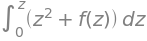

In [324]:
fz = sm.Function('f')(zS)
ex =(zS**2+fz).integrate((zS,0,zS))
ex

In [332]:
sm.lambdify([fz, zS], ex, modules='numpy')(arange(5),arange(5))

NameError: name 'Integral' is not defined